In [1]:
# Import packages

import pandas as pd 
import numpy as np 
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import statsmodels.api as sm
from scipy import stats

from joblib import dump, load

pd.set_option('display.max_columns', None)

In [2]:
nfl = pd.read_csv('../../data/nfl_game_by_game_raw_stats.csv')
qb_lookup = pd.read_csv('../../data/team_primary_qb_lookup.csv')

In [3]:
nfl.head()

,season,week,team,opponent,score,opponent_score,qb,total_pass_attempts,total_passing_yards,completions,passing_epa,pass_tds,air_yards,yards_after_catch,air_epa,yac_epa,avg_cpoe,total_rushes,total_rush_yards,rushing_epa,rush_tds,qb_epa,qb_rush_yards,qb_rushing_epa,qb_rush_tds,total_qb_rush_attempts,sacks_taken_qb,qb_hits_taken_qb,fumbles_qb,lost_fumbles_qb,interceptions_thrown_qb,sacks_allowed_team,qb_hits_allowed_team,fumbles_team,lost_fumbles_team,interceptions_thrown_team,total_rushes_allowed,total_rush_yards_allowed,rushing_epa_allowed,rush_tds_allowed,total_pass_attempts_allowed,passing_yards_allowed,completions_allowed,passing_epa_allowed,pass_tds_allowed,air_yards_allowed,yards_after_catch_allowed,air_epa_allowed,yac_epa_allowed,avg_cpoe_allowed,qb_epa_allowed,qb_rush_yards_allowed,qb_rushing_epa_allowed,qb_rush_tds_allowed,sacks,qb_hits,fumbles_forced,interceptions,fumbles_recovered,special_teams_epa,total_epa,total_opposing_epa
0,2014,1,ARI,LAC,18,17,C. Palmer,38,304.0,24.0,6.098425,2.0,196.0,108.0,10.800692,13.884696,3.160065,26,110.0,-7.697317,0.0,7.779734,30.0,1.681309,0.0,3.0,2.0,4.0,1.0,1.0,0.0,2.0,4.0,2.0,2.0,0.0,24,52.0,-8.805075,1.0,36,238.0,21.0,0.799435,1.0,148.0,90.0,8.328671,10.101167,-6.609174,-1.749010,10.0,-2.548446,0.0,0.0,4.0,0.0,1.0,0.0,-4.751772,1.654976,-1.654976
1,2014,1,ATL,NO,37,34,M. Ryan,42,448.0,31.0,17.253965,3.0,253.0,195.0,8.815695,16.383532,6.128030,25,123.0,2.559394,1.0,24.116820,15.0,0.272050,0.0,3.0,1.0,4.0,1.0,1.0,0.0,1.0,4.0,1.0,1.0,0.0,28,139.0,4.264254,3.0,42,333.0,29.0,9.202585,1.0,141.0,192.0,1.711281,22.435846,-0.291977,13.906331,2.0,-0.387024,0.0,0.0,0.0,1.0,1.0,1.0,-1.162613,5.183908,-5.183908
2,2014,1,BAL,CIN,16,23,J. Flacco,62,345.0,35.0,-4.871386,1.0,221.0,124.0,10.962930,14.313325,-11.889451,21,94.0,-0.093163,1.0,-3.078329,7.0,1.793058,0.0,3.0,3.0,6.0,0.0,0.0,1.0,3.0,6.0,1.0,1.0,1.0,24,81.0,-4.888501,0.0,39,303.0,25.0,11.252418,1.0,129.0,172.0,-3.613447,26.073280,-2.044220,7.354762,5.0,-3.897657,0.0,0.0,1.0,0.0,0.0,0.0,-2.107624,-13.436091,13.436091
3,2014,1,BUF,CHI,23,20,E. Manuel,22,173.0,16.0,0.368607,1.0,93.0,80.0,1.909633,9.530254,11.150598,31,197.0,4.315138,1.0,0.591515,23.0,0.222908,1.0,4.0,1.0,3.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0,1.0,18,86.0,-0.055888,0.0,49,349.0,34.0,-6.755498,2.0,159.0,190.0,3.427141,16.035978,2.864331,0.058386,0.0,0.000000,0.0,2.0,4.0,1.0,2.0,1.0,3.721131,15.216262,-15.216262
4,2014,1,CAR,TB,20,14,D. Anderson,33,230.0,24.0,8.423189,2.0,160.0,70.0,6.298791,10.724494,9.822589,33,113.0,-6.247634,0.0,10.352312,10.0,1.929123,0.0,3.0,1.0,3.0,1.0,0.0,0.0,1.0,3.0,1.0,0.0,0.0,17,102.0,1.025410,0.0,35,183.0,22.0,-10.437735,2.0,138.0,45.0,6.082325,4.351872,0.519191,-3.645375,27.0,2.277812,0.0,3.0,9.0,2.0,2.0,1.0,-3.457676,8.130204,-8.130204


In [4]:
# Previous iteration tried to predict passing value using a modeling approach. The issue I found with this is that it 
# is difficult to create a label corresponding to a "good" quarterback game. In this approach, the focus will be 
# transforming the necessary features using scaling/normalization/etc. This approach should result in minimal changes
# to the actual value of the feature, just changing the representation.

In [5]:
# Get only passing related stats for qbs that threw more than 10 passes in the game

# passing = nfl.copy()
# passing = passing[['season', 'week', 'team', 'opponent', 'score', 'opponent_score', 'qb', 'total_pass_attempts', 'total_passing_yards',
#         'completions', 'passing_epa', 'pass_tds', 'air_yards', 'yards_after_catch', 'air_epa', 'yac_epa', 'avg_cpoe',
#         'qb_epa', 'total_qb_rush_attempts', 'qb_rush_yards', 'qb_rushing_epa', 'qb_rush_tds', 'sacks_taken_qb', 'qb_hits_taken_qb', 'fumbles_qb',
#         'lost_fumbles_qb', 'interceptions_thrown_qb']]
# passing = passing[passing.total_pass_attempts > 10]
# passing

In [7]:
# Previous iteration used qbs that threw 10 or more passes in a game. This did end up with a lot of multiple rows because 
# of qb benchings, injuries, etc. This ended up getting confusing later down the line, and I don't know if having that 
# extra data is worth the hassle. For now, just taking the primary qb of each game, defined as the qb that threw the most 
# passes that week.

passing = nfl.copy()
passing = passing[['season', 'week', 'team', 'opponent', 'score', 'opponent_score', 'qb', 'total_pass_attempts', 'total_passing_yards',
        'completions', 'passing_epa', 'pass_tds', 'air_yards', 'yards_after_catch', 'air_epa', 'yac_epa', 'avg_cpoe',
        'qb_epa', 'total_qb_rush_attempts', 'qb_rush_yards', 'qb_rushing_epa', 'qb_rush_tds', 'sacks_taken_qb', 'qb_hits_taken_qb', 'fumbles_qb',
        'lost_fumbles_qb', 'interceptions_thrown_qb']]
passing = passing[passing.total_pass_attempts > 10]
passing = passing.merge(qb_lookup)
passing

,season,week,team,opponent,score,opponent_score,qb,total_pass_attempts,total_passing_yards,completions,passing_epa,pass_tds,air_yards,yards_after_catch,air_epa,yac_epa,avg_cpoe,qb_epa,total_qb_rush_attempts,qb_rush_yards,qb_rushing_epa,qb_rush_tds,sacks_taken_qb,qb_hits_taken_qb,fumbles_qb,lost_fumbles_qb,interceptions_thrown_qb,Unnamed: 0
0,2014,1,ARI,LAC,18,17,C. Palmer,38,304.0,24.0,6.098425,2.0,196.0,108.0,10.800692,13.884696,3.160065,7.779734,3.0,30.0,1.681309,0.0,2.0,4.0,1.0,1.0,0.0,0
1,2014,1,ATL,NO,37,34,M. Ryan,42,448.0,31.0,17.253965,3.0,253.0,195.0,8.815695,16.383532,6.128030,24.116820,3.0,15.0,0.272050,0.0,1.0,4.0,1.0,1.0,0.0,1
2,2014,1,BAL,CIN,16,23,J. Flacco,62,345.0,35.0,-4.871386,1.0,221.0,124.0,10.962930,14.313325,-11.889451,-3.078329,3.0,7.0,1.793058,0.0,3.0,6.0,0.0,0.0,1.0,2
3,2014,1,BUF,CHI,23,20,E. Manuel,22,173.0,16.0,0.368607,1.0,93.0,80.0,1.909633,9.530254,11.150598,0.591515,4.0,23.0,0.222908,1.0,1.0,3.0,0.0,0.0,1.0,3
4,2014,1,CAR,TB,20,14,D. Anderson,33,230.0,24.0,8.423189,2.0,160.0,70.0,6.298791,10.724494,9.822589,10.352312,3.0,10.0,1.929123,0.0,1.0,3.0,1.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4866,2022,21,KC,CIN,23,20,P. Mahomes,43,326.0,29.0,7.392085,2.0,155.0,171.0,3.489981,22.501547,2.263511,7.877727,3.0,8.0,0.485642,0.0,3.0,5.0,2.0,1.0,0.0,5864
4867,2022,21,PHI,SF,31,7,J. Hurts,25,121.0,15.0,-0.657053,0.0,71.0,50.0,0.958878,8.566836,-2.605077,0.835513,11.0,39.0,1.492567,1.0,1.0,2.0,0.0,0.0,0.0,5865
4868,2022,21,SF,PHI,7,31,J. Johnson,13,74.0,7.0,-2.025567,0.0,22.0,52.0,1.256181,3.990967,-5.467761,-6.616739,2.0,2.0,-4.591173,0.0,2.0,6.0,1.0,1.0,0.0,5868
4869,2022,22,KC,PHI,38,35,P. Mahomes,27,182.0,21.0,12.383465,3.0,102.0,80.0,-1.119444,18.910269,13.640325,15.936936,3.0,48.0,3.553472,0.0,0.0,5.0,0.0,0.0,0.0,5869


In [8]:
# test = passing[(passing.passing_epa) != (passing.qb_epa -passing.qb_rushing_epa)]
# test['difference'] = test.apply(lambda x: np.abs(x.passing_epa - (x.qb_epa - x.qb_rushing_epa)), axis=1)
# test = test[test.difference >.01]
# test.sort_values(by='difference', ascending=False)

In [9]:
# Look at the distribution of qb epa. Should it be left as is? Scaled?

np.mean(passing.qb_epa)

2.4491184789789493

In [10]:
np.max(passing.qb_epa)

40.139698

In [11]:
np.min(passing.qb_epa)

-37.038696

In [12]:
best_pass_performances = passing.sort_values(by='qb_epa', ascending=False)
best_pass_performances.head(20)

,season,week,team,opponent,score,opponent_score,qb,total_pass_attempts,total_passing_yards,completions,passing_epa,pass_tds,air_yards,yards_after_catch,air_epa,yac_epa,avg_cpoe,qb_epa,total_qb_rush_attempts,qb_rush_yards,qb_rushing_epa,qb_rush_tds,sacks_taken_qb,qb_hits_taken_qb,fumbles_qb,lost_fumbles_qb,interceptions_thrown_qb,Unnamed: 0
237,2014,8,PIT,IND,51,34,B. Roethlisberger,49,522.0,40.0,36.206100,6.0,296.0,226.0,18.347322,23.776966,16.915632,40.139698,1.0,-1.0,-1.443085,0.0,0.0,0.0,1.0,1.0,0.0,284
2802,2019,5,HOU,ATL,53,32,D. Watson,33,426.0,28.0,32.197030,5.0,222.0,204.0,15.549741,20.956861,17.858105,36.080143,4.0,47.0,3.883114,0.0,0.0,1.0,3.0,0.0,0.0,3323
3277,2020,3,KC,BAL,34,20,P. Mahomes,42,385.0,31.0,31.377850,4.0,207.0,178.0,6.965472,32.178870,9.400512,35.252430,4.0,26.0,3.874581,1.0,0.0,4.0,0.0,0.0,0.0,3893
4188,2021,16,CIN,BAL,41,21,J. Burrow,46,525.0,37.0,32.462337,4.0,279.0,246.0,13.691797,31.177887,14.204991,34.681343,1.0,12.0,2.219006,0.0,3.0,6.0,0.0,0.0,0.0,5033
2858,2019,7,GB,LV,42,24,A. Rodgers,31,429.0,25.0,31.815393,5.0,206.0,223.0,8.283893,29.595753,20.738749,32.614830,2.0,6.0,0.799438,1.0,1.0,3.0,0.0,0.0,0.0,3388
364,2014,13,HOU,TEN,45,21,R. Fitzpatrick,33,358.0,24.0,21.103912,6.0,178.0,180.0,12.331483,14.888274,10.078753,32.544125,2.0,10.0,1.401261,0.0,0.0,3.0,1.0,1.0,0.0,433
4319,2022,1,KC,ARI,44,21,P. Mahomes,39,360.0,30.0,28.897123,5.0,168.0,192.0,6.068593,27.857737,11.784186,32.338684,3.0,5.0,-0.849840,0.0,0.0,6.0,3.0,1.0,0.0,5203
2674,2019,1,DAL,NYG,35,17,D. Prescott,32,405.0,25.0,30.217525,4.0,232.0,173.0,15.304371,21.021845,8.916627,31.767210,2.0,14.0,1.549685,0.0,0.0,2.0,0.0,0.0,0.0,3171
233,2014,8,NE,CHI,51,23,T. Brady,35,354.0,30.0,33.512780,5.0,212.0,142.0,23.032400,13.724319,20.777046,31.670113,2.0,0.0,-1.842666,0.0,0.0,0.0,1.0,0.0,0.0,279
1595,2016,20,ATL,GB,44,21,M. Ryan,38,392.0,27.0,31.053396,4.0,190.0,202.0,10.615632,27.684484,7.060899,31.619041,3.0,23.0,0.565644,1.0,0.0,7.0,1.0,0.0,0.0,1879


In [13]:
worst_pass_performances = passing.sort_values(by='qb_epa', ascending=True)
worst_pass_performances.head(20)

,season,week,team,opponent,score,opponent_score,qb,total_pass_attempts,total_passing_yards,completions,passing_epa,pass_tds,air_yards,yards_after_catch,air_epa,yac_epa,avg_cpoe,qb_epa,total_qb_rush_attempts,qb_rush_yards,qb_rushing_epa,qb_rush_tds,sacks_taken_qb,qb_hits_taken_qb,fumbles_qb,lost_fumbles_qb,interceptions_thrown_qb,Unnamed: 0
2318,2018,7,ARI,DEN,10,45,J. Rosen,39,194.0,21.0,-38.896610,1.0,122.0,72.0,1.744368,12.277300,-10.159547,-37.038696,1.0,14.0,1.857912,0.0,6.0,11.0,3.0,2.0,3.0,2725
4237,2021,17,NYG,CHI,3,29,M. Glennon,11,24.0,4.0,-35.564820,0.0,0.0,24.0,-3.608493,2.536155,-29.181055,-34.458668,1.0,13.0,1.106152,0.0,4.0,5.0,4.0,2.0,2.0,5099
2813,2019,5,NYJ,PHI,6,31,L. Falk,27,120.0,15.0,-34.134060,0.0,38.0,82.0,-6.899850,12.142971,-7.548871,-34.134060,0.0,0.0,0.000000,0.0,9.0,15.0,2.0,1.0,2.0,3337
2871,2019,7,NYJ,NE,0,33,S. Darnold,32,86.0,11.0,-31.661474,0.0,67.0,19.0,1.590615,1.916720,-22.019503,-31.661474,0.0,0.0,0.000000,0.0,1.0,2.0,1.0,1.0,4.0,3405
1826,2017,8,MIA,BAL,0,40,M. Moore,44,176.0,25.0,-31.465069,0.0,122.0,54.0,-1.331060,6.678736,-10.349047,-31.465069,0.0,0.0,0.000000,0.0,3.0,7.0,0.0,0.0,2.0,2148
2880,2019,8,CAR,SF,13,51,K. Allen,37,158.0,19.0,-31.149303,0.0,73.0,85.0,-0.510800,9.992088,-16.359425,-31.149303,0.0,0.0,0.000000,0.0,7.0,9.0,0.0,0.0,3.0,3416
2716,2019,2,MIA,NE,0,43,R. Fitzpatrick,21,89.0,11.0,-31.658140,0.0,60.0,29.0,-1.276343,3.790076,-17.647066,-30.877289,1.0,6.0,0.780851,0.0,4.0,5.0,0.0,0.0,3.0,3220
1897,2017,11,CLE,JAX,7,19,D. Kizer,32,179.0,16.0,-31.420427,1.0,123.0,56.0,4.022449,6.143284,-9.638144,-30.844740,4.0,23.0,0.575688,0.0,5.0,5.0,3.0,2.0,2.0,2228
2340,2018,7,NYJ,MIN,17,37,S. Darnold,42,206.0,17.0,-27.981400,1.0,85.0,121.0,-1.612318,12.166667,-22.331995,-29.716560,6.0,18.0,-1.735161,1.0,3.0,3.0,2.0,1.0,3.0,2751
4764,2022,16,IND,LAC,3,20,N. Foles,29,143.0,17.0,-24.711033,0.0,85.0,58.0,0.868456,8.481685,-8.058896,-28.945805,1.0,0.0,-4.234771,0.0,7.0,9.0,0.0,0.0,3.0,5742


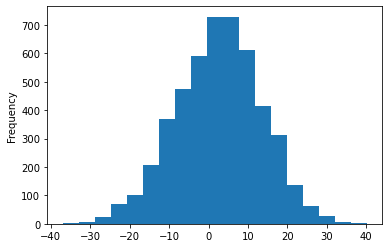

In [14]:
passing.qb_epa.plot.hist(bins=19)

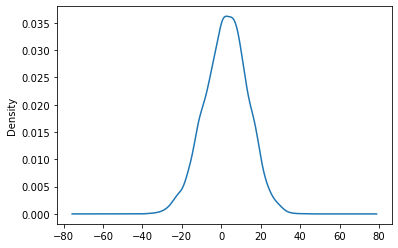

In [15]:
passing.qb_epa.plot.kde()

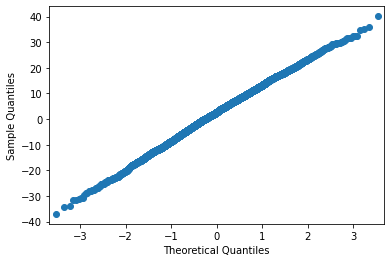

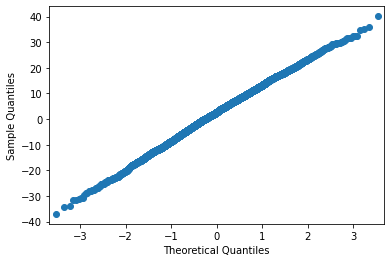

In [16]:
sm.qqplot(passing.qb_epa)

In [17]:
# Looks normal, creating a variable to normalize passing_epa
# Doing the same for passing_epa_per_play

qb_epa_mean = np.mean(passing.qb_epa)
qb_epa_std = np.std(passing.qb_epa)
passing['qb_epa_standardized'] = passing.apply(lambda x: (x.qb_epa - qb_epa_mean)/qb_epa_std, axis=1)

passing['qb_epa_per_attempt'] = passing.apply(lambda x: x.qb_epa/(x.total_pass_attempts + x.total_qb_rush_attempts), axis=1)

passing_no_glennon = passing[passing.qb_epa_per_attempt >= -2.5]
qb_epa_pa_mean = np.mean(passing_no_glennon.qb_epa_per_attempt)
qb_epa_pa_std = np.std(passing_no_glennon.qb_epa_per_attempt)
passing['qb_epa_per_attempt_standardized'] = passing.apply(lambda x: (x.qb_epa_per_attempt - qb_epa_pa_mean)/qb_epa_pa_std, axis=1)

passing.head()

,season,week,team,opponent,score,opponent_score,qb,total_pass_attempts,total_passing_yards,completions,passing_epa,pass_tds,air_yards,yards_after_catch,air_epa,yac_epa,avg_cpoe,qb_epa,total_qb_rush_attempts,qb_rush_yards,qb_rushing_epa,qb_rush_tds,sacks_taken_qb,qb_hits_taken_qb,fumbles_qb,lost_fumbles_qb,interceptions_thrown_qb,Unnamed: 0,qb_epa_standardized,qb_epa_per_attempt,qb_epa_per_attempt_standardized
0,2014,1,ARI,LAC,18,17,C. Palmer,38,304.0,24.0,6.098425,2.0,196.0,108.0,10.800692,13.884696,3.160065,7.779734,3.0,30.0,1.681309,0.0,2.0,4.0,1.0,1.0,0.0,0,0.491486,0.189750,0.379430
1,2014,1,ATL,NO,37,34,M. Ryan,42,448.0,31.0,17.253965,3.0,253.0,195.0,8.815695,16.383532,6.128030,24.116820,3.0,15.0,0.272050,0.0,1.0,4.0,1.0,1.0,0.0,1,1.997776,0.535929,1.461035
2,2014,1,BAL,CIN,16,23,J. Flacco,62,345.0,35.0,-4.871386,1.0,221.0,124.0,10.962930,14.313325,-11.889451,-3.078329,3.0,7.0,1.793058,0.0,3.0,6.0,0.0,0.0,1.0,2,-0.509634,-0.047359,-0.361392
3,2014,1,BUF,CHI,23,20,E. Manuel,22,173.0,16.0,0.368607,1.0,93.0,80.0,1.909633,9.530254,11.150598,0.591515,4.0,23.0,0.222908,1.0,1.0,3.0,0.0,0.0,1.0,3,-0.171272,0.022751,-0.142342
4,2014,1,CAR,TB,20,14,D. Anderson,33,230.0,24.0,8.423189,2.0,160.0,70.0,6.298791,10.724494,9.822589,10.352312,3.0,10.0,1.929123,0.0,1.0,3.0,1.0,0.0,0.0,4,0.728679,0.287564,0.685042


In [18]:
# Still not sure whats best. Per attempt gives higher praise for good games w few passes and penalized more heavily for
# bad games with fewer passes. Going to start with total, but may need to change this later.

qb_to_save = passing.copy()
qb_to_save['qb_value'] = qb_to_save.qb_epa_standardized
qb_to_save.head()

,season,week,team,opponent,score,opponent_score,qb,total_pass_attempts,total_passing_yards,completions,passing_epa,pass_tds,air_yards,yards_after_catch,air_epa,yac_epa,avg_cpoe,qb_epa,total_qb_rush_attempts,qb_rush_yards,qb_rushing_epa,qb_rush_tds,sacks_taken_qb,qb_hits_taken_qb,fumbles_qb,lost_fumbles_qb,interceptions_thrown_qb,Unnamed: 0,qb_epa_standardized,qb_epa_per_attempt,qb_epa_per_attempt_standardized,qb_value
0,2014,1,ARI,LAC,18,17,C. Palmer,38,304.0,24.0,6.098425,2.0,196.0,108.0,10.800692,13.884696,3.160065,7.779734,3.0,30.0,1.681309,0.0,2.0,4.0,1.0,1.0,0.0,0,0.491486,0.189750,0.379430,0.491486
1,2014,1,ATL,NO,37,34,M. Ryan,42,448.0,31.0,17.253965,3.0,253.0,195.0,8.815695,16.383532,6.128030,24.116820,3.0,15.0,0.272050,0.0,1.0,4.0,1.0,1.0,0.0,1,1.997776,0.535929,1.461035,1.997776
2,2014,1,BAL,CIN,16,23,J. Flacco,62,345.0,35.0,-4.871386,1.0,221.0,124.0,10.962930,14.313325,-11.889451,-3.078329,3.0,7.0,1.793058,0.0,3.0,6.0,0.0,0.0,1.0,2,-0.509634,-0.047359,-0.361392,-0.509634
3,2014,1,BUF,CHI,23,20,E. Manuel,22,173.0,16.0,0.368607,1.0,93.0,80.0,1.909633,9.530254,11.150598,0.591515,4.0,23.0,0.222908,1.0,1.0,3.0,0.0,0.0,1.0,3,-0.171272,0.022751,-0.142342,-0.171272
4,2014,1,CAR,TB,20,14,D. Anderson,33,230.0,24.0,8.423189,2.0,160.0,70.0,6.298791,10.724494,9.822589,10.352312,3.0,10.0,1.929123,0.0,1.0,3.0,1.0,0.0,0.0,4,0.728679,0.287564,0.685042,0.728679


In [19]:
qb_to_save.to_csv('qb_value_model_v2_data/qb_with_value.csv')

In [20]:
# Look at best/worst qbs by passing epa standardized

qbs = passing.groupby(by=['qb']).agg({'qb_epa_standardized': 'mean', 'week':'count'}).reset_index()
qbs

,qb,qb_epa_standardized,week
0,A. Brown,-1.587482,1
1,A. Dalton,-0.103625,113
2,A. Davis,-0.848541,11
3,A. Luck,0.208496,58
4,A. McCarron,-0.237355,6
...,...,...,...
154,T. Taylor,0.017500,52
155,T. Yates,-0.627093,5
156,W. Grier,-1.657789,1
157,Z. Mettenberger,-0.896911,10


In [21]:
qbs[qbs.week>=10].sort_values(by='qb_epa_standardized', ascending = True).head(20)

,qb,qb_epa_standardized,week
84,J. Rosen,-1.258598,16
157,Z. Mettenberger,-0.896911,10
2,A. Davis,-0.848541,11
101,M. Glennon,-0.831514,20
44,D. Haskins,-0.819801,13
100,M. Cassel,-0.817813,11
47,D. Kizer,-0.802442,15
13,B. Hundley,-0.769679,10
158,Z. Wilson,-0.749566,21
127,R. Griffin,-0.748656,13


In [22]:
qbs[qbs.week>=10].sort_values(by='qb_epa_standardized', ascending = False).head(20)

,qb,qb_epa_standardized,week
121,P. Mahomes,0.936493,93
41,D. Brees,0.463792,107
142,T. Brady,0.443913,163
150,T. Romo,0.434211,21
63,J. Allen,0.403400,83
5,A. Rodgers,0.402048,146
65,J. Burrow,0.341967,49
96,L. Jackson,0.341670,63
74,J. Garoppolo,0.339755,61
77,J. Hurts,0.325704,38


In [23]:
qbs2 = passing.groupby(by=['qb', 'season']).agg({'qb_epa_standardized': 'mean', 'week':'count'}).reset_index()
qbs2

,qb,season,qb_epa_standardized,week
0,A. Brown,2022,-1.587482,1
1,A. Dalton,2014,-0.236972,17
2,A. Dalton,2015,0.663245,12
3,A. Dalton,2016,0.173361,16
4,A. Dalton,2017,-0.408289,16
...,...,...,...,...
528,W. Grier,2019,-1.657789,1
529,Z. Mettenberger,2014,-0.583924,6
530,Z. Mettenberger,2015,-1.366391,4
531,Z. Wilson,2021,-0.903539,12


In [24]:
qbs2[qbs2.week>=10].sort_values(by='qb_epa_standardized', ascending = False).head(20)

,qb,season,qb_epa_standardized,week
409,P. Mahomes,2018,1.068842,18
413,P. Mahomes,2022,0.988469,20
411,P. Mahomes,2020,0.975885,18
410,P. Mahomes,2019,0.969989,16
24,A. Rodgers,2020,0.914671,18
359,M. Ryan,2016,0.905005,19
320,L. Jackson,2019,0.891010,16
481,T. Brady,2016,0.876759,15
18,A. Rodgers,2014,0.778669,18
143,D. Brees,2018,0.776950,17


In [25]:
qbs2[qbs2.week>=10].sort_values(by='qb_epa_standardized', ascending = True).head(20)

,qb,season,qb_epa_standardized,week
283,J. Rosen,2018,-1.245688,13
392,N. Foles,2015,-0.984541,11
531,Z. Wilson,2021,-0.903539,12
37,B. Bortles,2014,-0.820639,14
163,D. Kizer,2017,-0.774015,14
53,B. Hundley,2017,-0.769679,10
129,C. Wentz,2020,-0.769570,12
466,S. Darnold,2021,-0.754078,12
465,S. Darnold,2020,-0.710433,12
235,J. Fields,2021,-0.690747,10
